# B value vs Nea. ancestry using f4 ratios

In [1]:
suppressPackageStartupMessages({

library(tidyverse)
library(admixr)

source("../code/utils.R")
source("../code/assign_bvals.R")

})

#### Read Big Yoruba sites

In [2]:
big_YRI <- read_snp("../data/eigenstrat/bigyri_ho/all_BigYRI.snp") %>% 
    filter(chrom %in% 1:22) %>% 
    mutate(chrom=paste0("chr", chrom), start=pos - 1, end=pos) %>%
    makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE) %>% 
    assign_bvals(bval_path="../data/bkgd/", chain_path="../data/hg18ToHg19.over.chain") %>%
    as.data.frame %>%
    select(chrom=seqnames, pos=end, bval) %>%
    mutate(bin=cut(bval, seq(0, 1000, 100)))

Warning message:
“closing unused connection 4 (../data/hg18ToHg19.over.chain)”

#### Read Human Origins sites

In [3]:
humorig <-  read_snp("../data/eigenstrat/bigyri_ho/all_HO.snp") %>% 
    filter(chrom %in% 1:22) %>% 
    mutate(chrom=paste0("chr", chrom), start=pos - 1, end=pos) %>%
    makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE) %>% 
    assign_bvals(bval_path="../data/bkgd/", chain_path="../data/hg18ToHg19.over.chain") %>%
    as.data.frame %>%
    select(chrom=seqnames, pos=end, bval) %>%
    mutate(bin=cut(bval, seq(0, 1000, 100)))

Warning message in .Internal(eval(expr, envir, enclos)):
“closing unused connection 4 (../data/hg18ToHg19.over.chain)”

#### Read archaic admixture array sites

In [4]:
aa_sites <- read_tsv("../data/genotypes/ice_age.tsv") %>% 
    mutate(chrom=paste0("chr", chrom), start=pos - 1, end=pos) %>%
    makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE) %>% 
    assign_bvals(bval_path="../data/bkgd/", chain_path="../data/hg18ToHg19.over.chain") %>%
    as.data.frame

Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Warning message:
“closing unused connection 4 (../data/hg18ToHg19.over.chain)”

In [5]:
nrow(big_YRI)
nrow(humorig)
nrow(aa_sites)

[1] 519434

[1] 1059687

[1] 945124

#### Read genome-wide B value regions

In [6]:
bval_files <- list.files("../data/bkgd/", full.names = TRUE, ".*.bkgd")
bval_df_list <- lapply(bval_files, function(filename) {
    read.table(filename, col.names = c("bval", "length")) %>% 
        mutate(chr = str_replace(basename(filename), ".bkgd", 
            ""), end = cumsum(length), start = c(1, (end + 
            1)[-n()])) %>% select(chr, start, end, bval)
})
bval_regions_hg18 <- bind_rows(bval_df_list)

In [7]:
bvals <- bind_rows(
    data.frame(bval=big_YRI$bval, sites="Big Yoruba"),
    data.frame(bval=humorig$bval, sites="Human Origins"),
    data.frame(bval=aa_sites$bval, sites="archaic admixture array"),
    data.frame(bval=bval_regions_hg18$bval, sites="genome-wide B values")
) %>% mutate(sites=factor(sites))

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

Warning message:
“Removed 252 rows containing non-finite values (stat_density).”

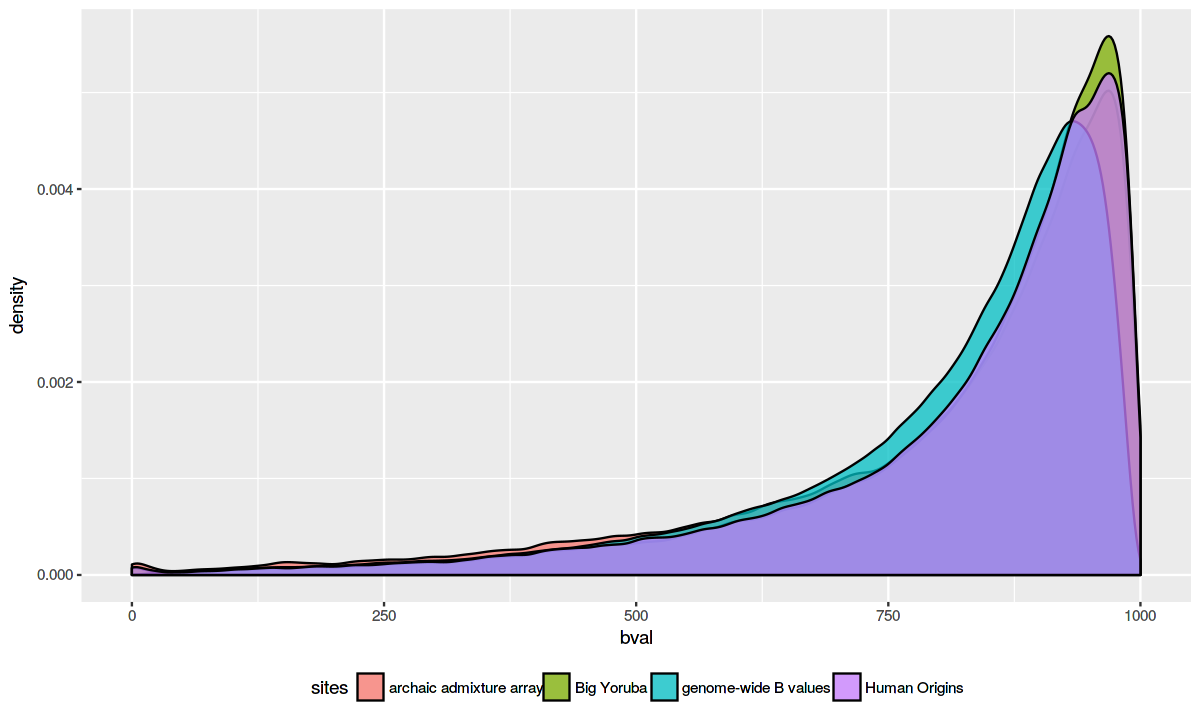

In [8]:
options(repr.plot.width=10, repr.plot.height=6)

ggplot(bvals, aes(bval, fill=sites)) +
    geom_density(alpha=0.75) +
    scale_colour_manual(values = c("red", "green", "blue")) + 
    theme(legend.position="bottom")

In [11]:
filter(bvals, sites == "Big Yoruba") %>% .[["bval"]] %>% mean(na.rm=T)

[1] 827.9272

In [12]:
filter(bvals, sites == "archaic admixture array") %>% .[["bval"]] %>% mean(na.rm=T)

[1] 802.8912

In [27]:
group_by(bvals, sites) %>% summarise(mean(bval, na.rm=TRUE), sd(bval, na.rm=TRUE), quantile(na.rm=TRUE, bval, probs=0.1))

sites,"mean(bval, na.rm = TRUE)","sd(bval, na.rm = TRUE)","quantile(na.rm = TRUE, bval, probs = 0.1)"
admixture array,802.8912,196.8851,514
big Yoruba + human origins,920.9962,102.0883,787
genome-wide B values,803.5139,172.9799,561


# This is crazy! Nearly all 2.2M sites are within high B value regions.

This makes the huge decline from 5-6% to 1-2% today even more unlikely.

In [90]:
table(f4_sites$bin)


    (0,100]   (100,200]   (200,300]   (300,400]   (400,500]   (500,600] 
          0           0         493        2324       10725       28619 
  (600,700]   (700,800]   (800,900] (900,1e+03] 
      64828      112023      259126     1466127 